<a href="https://colab.research.google.com/github/ancestor9/Practical-Machine-Learning-for-Computer-Vision-/blob/main/Chapter2_ML_Models_for_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flowers Image Classification using a linear model

We'll be using a creative-commons licensed
[flower photo dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers)
of 3670 images falling into 5 categories:
<pre>
'daisy', 'roses', 'dandelion', 'sunflowers', and 'tulips'
</pre>
We have already prepared these images to be stored
in Google Cloud Storage in a public bucket:
<pre>
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/.
</pre>

The images are randomly split
into a training set with 90% data and a
test set with 10% data listed in CSV files:

Training set: [train_set.csv](https://storage.cloud.google.com/practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv)
Evaluation set: [eval_set.csv](https://storage.cloud.google.com/practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv)


## Enable GPU

This notebook and pretty much every other notebook in this repository
will run faster if you are using a GPU.
On Colab:
- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
- Navigate to https://console.cloud.google.com/ai-platform/notebooks
- Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [2]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.19.0
Found GPU at: /device:GPU:0


## Let's examine these images

Let's see the first five lines of the train_set.csv
You'll notice that each line consists of a JPEG filename
and the type of flower it is.

In [1]:
!gsutil cat gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv | head -20

ServiceException: 401 Anonymous caller does not have storage.objects.get access to the Google Cloud Storage object. Permission 'storage.objects.get' denied on resource (or it may not exist).


In [3]:
import os
current_path = os.getcwd()
current_path

'/content'

In [19]:
import pathlib
import tensorflow as tf
import os

current_path = os.getcwd()  # w저장 현재 위치

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tgz', origin=dataset_url, untar=True, cache_dir=current_path)
# Update data_dir to point to the extracted directory
data_dir = os.path.join(data_dir, 'flower_photos')
data_dir

'/content/datasets/flower_photos_extracted/flower_photos'

In [25]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import glob

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)


# 1. glob을 사용하여 하위 폴더(클래스) 경로 전체 목록 가져오기
# *는 하위 디렉토리 이름을 의미합니다.
all_class_paths = glob.glob(os.path.join(data_dir, "*"))

# 2. 경로에서 클래스 이름만 추출
# os.path.basename을 사용하면 경로의 마지막 부분(디렉토리 이름)만 깔끔하게 추출됩니다.
CLASS_NAMES = [os.path.basename(path) for path in all_class_paths]

CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

These are the available classes: ['tulips', 'sunflowers', 'dandelion', 'daisy', 'roses']


In [27]:
os.path.join(data_dir, "daisy")

'/content/datasets/flower_photos_extracted/flower_photos/daisy'

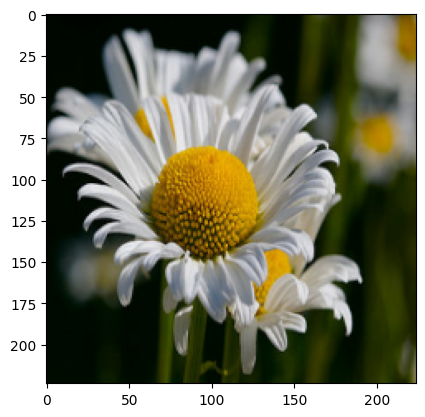

In [29]:
# Try reading and displaying one of the files
def show_image(filename):
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  plt.imshow((img.numpy()));

show_image(f"{os.path.join(data_dir, "daisy")}/754296579_30a9ae018c_n.jpg")

/content/datasets/flower_photos_extracted/flower_photos/tulips/100930342_92e8746431_n.jpg
/content/datasets/flower_photos_extracted/flower_photos/tulips/3150964108_24dbec4b23_m.jpg
/content/datasets/flower_photos_extracted/flower_photos/tulips/8706523526_a0f161b72b.jpg
/content/datasets/flower_photos_extracted/flower_photos/tulips/5470898169_52a5ab876c_n.jpg
/content/datasets/flower_photos_extracted/flower_photos/tulips/14061132852_89122de5f9_n.jpg


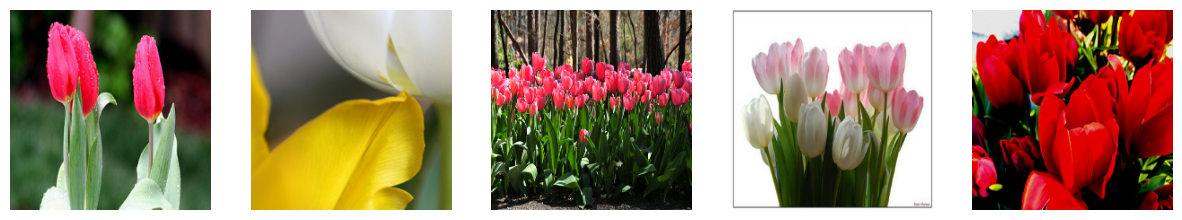

In [30]:
# notice that the file name has the flower type in it. Let's look at a few tulips
tulips = tf.io.gfile.glob(f"{os.path.join(data_dir, "tulips")}/*.jpg")
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate(tulips[:5]):
  print(filename)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()));
  ax[idx].axis('off')

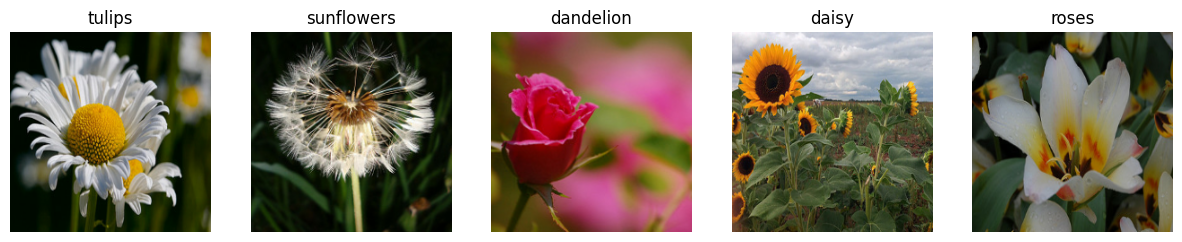

In [31]:
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate([
  f"{os.path.join(data_dir, "daisy")}/754296579_30a9ae018c_n.jpg",
  f"{os.path.join(data_dir, "dandelion")}/3554992110_81d8c9b0bd_m.jpg",
  f"{os.path.join(data_dir, "roses")}/7420699022_60fa574524_m.jpg",
  f"{os.path.join(data_dir, "sunflowers")}/21518663809_3d69f5b995_n.jpg",
  f"{os.path.join(data_dir, "tulips")}/8713398906_28e59a225a_n.jpg"
]):
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()));
  ax[idx].set_title(CLASS_NAMES[idx])
  ax[idx].axis('off')

## Keras 유틸리티를 사용하여 데이터 로드하기

In [32]:
batch_size = 32
img_height = 180
img_width = 180

In [33]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [34]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [35]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


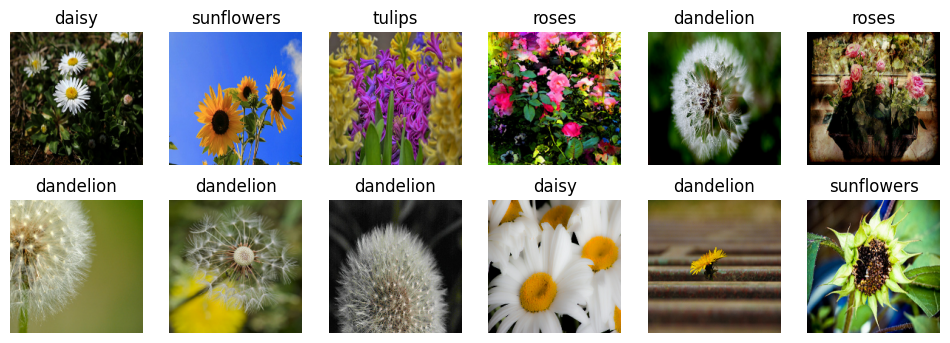

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(2, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## A simple rule-based model

Let's get the average color of RGB values in the different
types of flowers and then classify an unknown image as
belonging to closest centroid.

This will take a while if we do all the images,
since there are about 800 images
per type of flower. Later in the book, we will look at
ways to speed up full passes through the data.

That's pretty much a random guess!!

## A linear model
What if you apply different weights each of the pixels?
Let's use the [Tensorflow Keras API_click here](https://www.tensorflow.org/tutorials/images/classification?hl=ko)

In [52]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


[0.09405971 0.0570501  0.8488902 ]
[0.04838873 0.0721875  0.8794238 ]


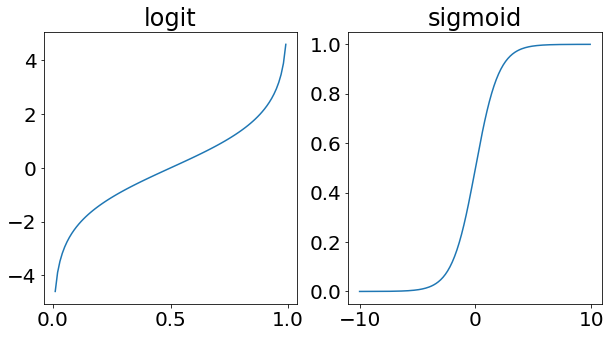

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

fig, ax = plt.subplots(1, 2, figsize=(10,5))
x = np.arange(0.01, 1.0, 0.01)
y = np.log(x / (1-x))
ax[0].plot(x, y)
ax[0].set_title("logit")
x = np.arange(-10.0, 10.0, 0.1)
y = tf.math.sigmoid(x)
ax[1].plot(x, y);
ax[1].set_title("sigmoid")

print( tf.math.softmax([-1.0, -1.5, 1.2]).numpy() )
print( tf.math.softmax([0.1, 0.5, 3.0]).numpy() )

## Diagrams


[0.   0.09 0.06 0.85 0.  ] [0.         0.01696592 0.01094963 0.9720845  0.        ]
[0.09090909 0.09090909 0.6363636  0.09090909 0.09090909] [0.04651164 0.04651164 0.8139535  0.04651164 0.04651164]
[0.   0.25 0.5  0.25 0.  ] [0.        0.2       0.6000001 0.2       0.       ]
[0.08333333 0.08333333 0.3333333  0.41666666 0.08333333] [0.06113537 0.06113537 0.33624452 0.48034936 0.06113537]
[0.125 0.125 0.5   0.125 0.125] [0.09090909 0.09090909 0.6363636  0.09090909 0.09090909]


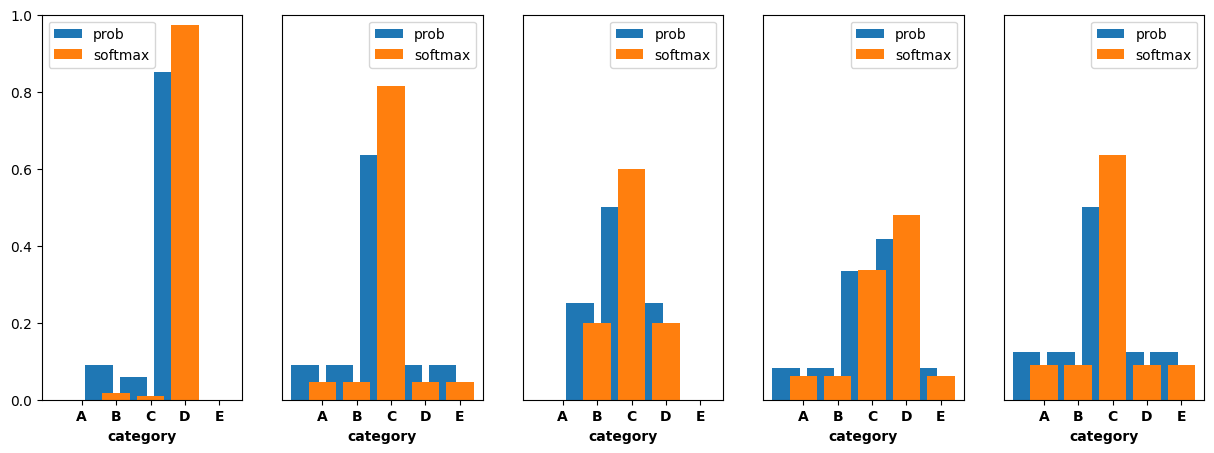

In [51]:
import tensorflow as tf

inx = [
    [0, 0.09, 0.06, 0.85, 0],
    [0.1, 0.1, 0.7, 0.1, 0.1],
    [0, 0.2, 0.4, 0.2, 0],
    [0.1, 0.1, 0.4, 0.5, 0.1],
    [0.2, 0.2, 0.8, 0.2, 0.2],
]

def logit(x):
    return - tf.math.log(1. / x - 1.)

barWidth = 0.5
r1 = np.arange(len(inx[0]))
r2 = [x + barWidth for x in r1]

f, ax = plt.subplots(1, 5, figsize=(15,5))
for idx, x in enumerate(inx):
    prob = x / tf.reduce_sum(x)
    softmax = tf.nn.softmax(logit(prob))
    print(prob.numpy(), softmax.numpy())
    ax[idx].bar(r1, prob, label='prob')
    ax[idx].bar(r2, softmax, label='softmax')
    ax[idx].set_xlabel('category', fontweight='bold')
    ax[idx].set_xticks(r2)
    ax[idx].set_xticklabels(['A','B','C','D','E'], fontweight='bold')
    ax[idx].set_ylim([0,1])
    if idx > 0:
        ax[idx].yaxis.set_visible(False)
    ax[idx].legend()

## **<font color="orange"> 책에 있는 내용을 tensoflow image classification 코드를 참고하여 자습하기**

## **Image Regression**

In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# 1. 모델 정의 (이미지 분류 모델과 다른 부분)

def create_regression_model(input_shape):
    model = keras.Sequential([
        # CNN 레이어: 이미지 특징 추출
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),

        # Dense 레이어
        layers.Dense(64, activation='relu'),

        # 🌟 핵심: 이미지 회귀를 위한 출력 레이어 🌟
        # 1. 유닛 수: 예측할 수치 값의 개수 (여기서는 '1'개, 강우량)
        # 2. 활성화 함수: 'None' (또는 'linear')을 사용하여 연속적인 실수 값을 출력
        layers.Dense(1, activation='linear') # 또는 activation=None
    ])
    return model

# 2. 모델 컴파일 (손실 함수가 다른 부분)

input_shape = (32, 32, 3) # 예: 32x32 RGB 이미지
model = create_regression_model(input_shape)

# 🌟 핵심: 회귀 문제에 적합한 손실 함수 사용 🌟
# 회귀에는 평균 제곱 오차(MSE)나 평균 절대 오차(MAE)를 주로 사용합니다.
model.compile(optimizer='adam',
              loss='mse', # Mean Squared Error (평균 제곱 오차)
              metrics=['mae']) # Mean Absolute Error (평균 절대 오차)

model.summary()


# 3. 가상 데이터 생성 및 학습 (예시)

# 입력 이미지 데이터 (100개, 32x32, RGB)
X_train = np.random.rand(100, 32, 32, 3).astype('float32')

# 레이블 데이터: 예측해야 할 연속적인 실수 값 (예: 0.0 mm ~ 10.0 mm 사이의 강우량)
Y_train = np.random.uniform(0.0, 10.0, 100).astype('float32')

print("\n--- 학습 시작 (가상 데이터) ---")
# 모델 학습
model.fit(X_train, Y_train, epochs=5, verbose=0)

print("--- 학습 완료 ---")

# 4. 예측 (테스트)
X_test = np.random.rand(1, 32, 32, 3).astype('float32')
prediction = model.predict(X_test)

print(f"\n입력 이미지에 대한 예측 강우량 (mm): {prediction[0][0]:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,977 (652.25 KB)

 Trainable params: 166,977 (652.25 KB)

 Non-trainable params: 0 (0.00 B)


--- 학습 시작 (가상 데이터) ---
--- 학습 완료 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step

입력 이미지에 대한 예측 강우량 (mm): 5.0204


Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## **Batch Normalization**

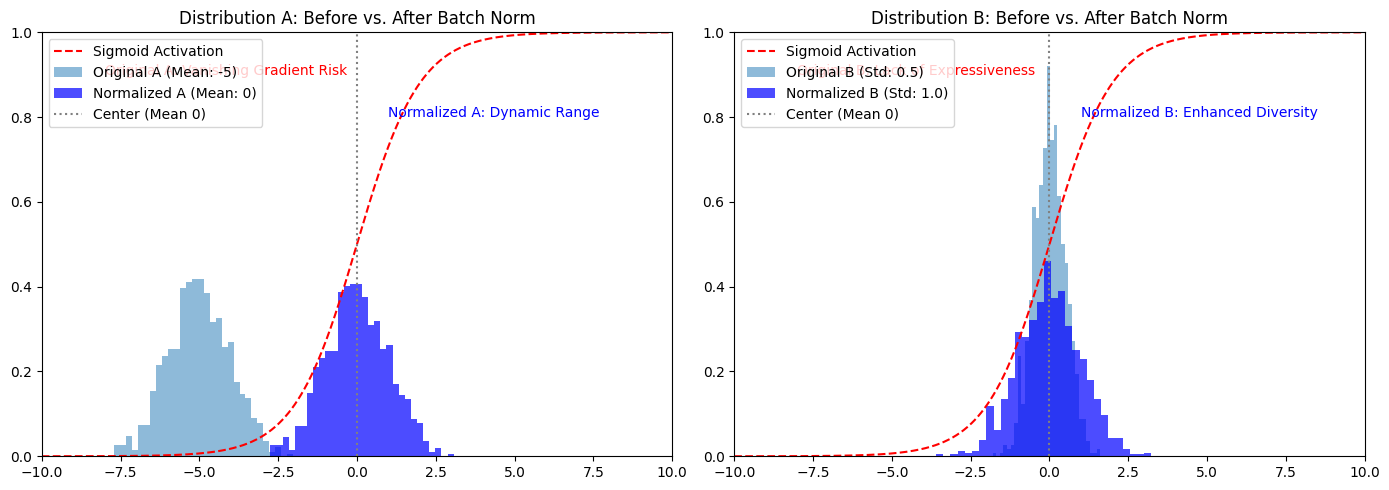

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 시그모이드 활성화 함수 정의
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 2. 가상의 뉴런 출력 데이터 생성 (Batch Norm 이전)
# 분포 A: 왼쪽 극단에 치우쳐 기울기 소실 위험 (예: 평균 -5, 표준편차 1)
data_A = np.random.normal(loc=-5.0, scale=1.0, size=1000)
# 분포 B: 너무 좁게 모여있어 표현력이 부족 (예: 평균 0, 표준편차 0.5)
data_B = np.random.normal(loc=0.0, scale=0.5, size=1000)

# 3. 배치 정규화 (표준화 단계: 평균 0, 분산 1)
# 3-1. 분포 A의 정규화 (Batch Norm 적용)
mean_A = np.mean(data_A)
std_A = np.std(data_A)
normalized_A = (data_A - mean_A) / std_A

# 3-2. 분포 B의 정규화 (Batch Norm 적용)
mean_B = np.mean(data_B)
std_B = np.std(data_B)
normalized_B = (data_B - mean_B) / std_B

# 4. 시각화
x_range = np.linspace(-10, 10, 1000)

plt.figure(figsize=(14, 5))

# --- 분포 A 시각화 ---
plt.subplot(1, 2, 1)
plt.title('Distribution A: Before vs. After Batch Norm')
plt.plot(x_range, sigmoid(x_range), 'r--', label='Sigmoid Activation')

# Batch Norm 이전 (치우친 분포)
plt.hist(data_A, bins=30, density=True, alpha=0.5, label='Original A (Mean: -5)')
# Batch Norm 이후 (중앙으로 이동)
plt.hist(normalized_A, bins=30, density=True, alpha=0.7, color='blue', label='Normalized A (Mean: 0)')

plt.axvline(0, color='gray', linestyle=':', label='Center (Mean 0)')
plt.xlim(-10, 10)
plt.ylim(0, 1)
plt.legend(loc='upper left')
plt.text(-8, 0.9, 'Original A: Vanishing Gradient Risk', color='red')
plt.text(1, 0.8, 'Normalized A: Dynamic Range', color='blue')


# --- 분포 B 시각화 ---
plt.subplot(1, 2, 2)
plt.title('Distribution B: Before vs. After Batch Norm')
plt.plot(x_range, sigmoid(x_range), 'r--', label='Sigmoid Activation')

# Batch Norm 이전 (너무 좁은 분포)
plt.hist(data_B, bins=30, density=True, alpha=0.5, label='Original B (Std: 0.5)')
# Batch Norm 이후 (분산 1로 확장)
plt.hist(normalized_B, bins=30, density=True, alpha=0.7, color='blue', label='Normalized B (Std: 1.0)')

plt.axvline(0, color='gray', linestyle=':', label='Center (Mean 0)')
plt.xlim(-10, 10)
plt.ylim(0, 1)
plt.legend(loc='upper left')
plt.text(-8, 0.9, 'Original B: Lack of Expressiveness', color='red')
plt.text(1, 0.8, 'Normalized B: Enhanced Diversity', color='blue')

plt.tight_layout()
plt.show()